In [0]:
import os
import random
import glob

import numpy as np
from PIL import Image
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Loading MNIST Dataset from keras

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [30]:
print(f'Shape of training dataset: {np.shape(X_train)}')
print(f'Shape of testing dataset: {np.shape(X_test)}')

Shape of training dataset: (60000, 28, 28)
Shape of testing dataset: (10000, 28, 28)


In [0]:
#Creating Custom Dataset for digits in sequence

def build_dataset(data, labels, dataset_size):
  new_img_width = 64
  new_img_height = 64

  new_data = np.ndarray(shape=(dataset_size, new_img_height, new_img_width), dtype=np.float32)
  new_labels = []

  for i in range(0, dataset_size):
    num_digits = random.randint(1, 5)

    indices = [random.randint(0, len(data)-1) for _ in range(0, num_digits)]
    new_image = np.hstack([X_train[index] for index in indices])
    new_label = [y_train[index] for index in indices]

    for j in range(0, 5-num_digits):
      new_image = np.hstack([new_image, np.zeros((28, 28))])
      new_label.append(10)

    new_image = np.array(Image.fromarray(new_image).resize((64, 64)))
    new_data[i,:,:] = new_image
    new_labels.append(tuple(new_label))
  
  return new_data, new_labels


In [0]:
#Building new Training and Testing Dataset

X_new_train, y_new_train = build_dataset(X_train, y_train, 60000)
X_new_test, y_new_test = build_dataset(X_train, y_train, 60000)

(0, 4, 10, 10, 10)


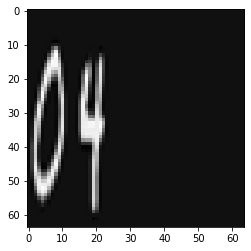

In [39]:
plt.figure()
plt.imshow(X_new_train[102], cmap='gray')
print(y_new_train[102])

# here 10 shows empty space

In [0]:
#Conver labels to One-hot representation of shape (set_Size, digits, classes)

possible_classes = 11

def convert_labels(labels):
  dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) 
  dig4_arr = np.ndarray(shape=(len(labels),possible_classes))

  for index, label in enumerate(labels):
    dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
    dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
    dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
    dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
    dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)

  return [dig0_arr, dig1_arr, dig2_arr, dig3_arr, dig4_arr]

In [41]:
train_labels = convert_labels(y_new_train)
test_labels = convert_labels(y_new_test)

print(np.shape(train_labels[0]))

(60000, 11)


In [0]:
#Preprocessing Images

def process_data(img_data):
  img_data = img_data.reshape(len(img_data),64,64,1)
  img_Data = img_data.astype('float32')
  img_data = img_Data/255
  return img_data

In [0]:
train_images = process_data(X_new_train)
test_images = process_data(X_new_test)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPool2D

In [81]:
# Model Building

batch_size = 128

inputs = Input(shape=(64, 64, 1))

cov = Convolution2D(32, 3, 3,border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(32, 3, 3, border_mode='same')(cov)
cov = Activation('relu')(cov)
cov = MaxPool2D(pool_size=(2, 2))(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)

cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)

c0 = Dense(11, activation='softmax')(cov2)
c1 = Dense(11, activation='softmax')(cov2)
c2 = Dense(11, activation='softmax')(cov2)
c3 = Dense(11, activation='softmax')(cov2)
c4 = Dense(11, activation='softmax')(cov2)

model = Model(input=inputs, output=[c0, c1, c2, c3, c4])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [83]:
model.fit(train_images, train_labels, batch_size=batch_size, nb_epoch=12, 
          verbose=1, validation_data=(test_images, test_labels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 60000 samples, validate on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 31s 522us/step - loss: 3.7339 - dense_3_loss: 0.9419 - dense_4_loss: 0.9038 - dense_5_loss: 0.8014 - dense_6_loss: 0.6491 - dense_7_loss: 0.4370 - dense_3_accuracy: 0.6831 - dense_4_accuracy: 0.7017 - dense_5_accuracy: 0.7390 - dense_6_accuracy: 0.7912 - dense_7_accuracy: 0.8619 - val_loss: 1.0821 - val_dense_3_loss: 0.2447 - val_dense_4_loss: 0.2384 - val_dense_5_loss: 0.2201 - val_dense_6_loss: 0.2026 - val_dense_7_loss: 0.1764 - val_dense_3_accuracy: 0.9500 - val_dense_4_accuracy: 0.9513 - val_dense_5_accuracy: 0.9552 - val_dense_6_accuracy: 0.9605 - val_dense_7_accuracy: 0.9561
Epoch 2/12
60000/60000 [==============================] - 24s 405us/step - loss: 2.3892 - dense_3_loss: 0.5734 - dense_4_loss: 0.5647 - dense_5_loss: 0.5196 - dense_6_loss: 0.4354 - dense_7_loss: 0.2961 - dense_3_accuracy: 0.8097 - dense_4_accuracy: 0.8111 - dense_5_accuracy: 0.8248 - dense_6_accuracy:

In [0]:
#Function for calculating Accuracy

def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy


In [0]:
predictions = model.predict(test_images)

ind_Acc, glob_acc = cal_acc(predictions, test_labels)

In [117]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
    print(i)
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

7838
Actual labels: [4, 10, 10, 10, 10]
Predicted labels: [4, 10, 10, 10, 10]

7174
Actual labels: [0, 5, 10, 10, 10]
Predicted labels: [0, 5, 10, 10, 10]

7773
Actual labels: [6, 4, 10, 10, 10]
Predicted labels: [6, 4, 10, 10, 10]

7079
Actual labels: [8, 0, 1, 10, 10]
Predicted labels: [8, 0, 1, 10, 10]

3012
Actual labels: [9, 6, 6, 10, 10]
Predicted labels: [9, 6, 6, 10, 10]



Real:  (4, 7, 8, 7, 10)
Predicted:  [4, 7, 8, 7, 10]


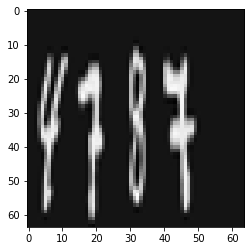

In [125]:
ind = 2025

predicted_labels = []
for j in range(0,5):
  predicted_labels.append(np.argmax(predictions[j][ind]))

plt.imshow(X_new_test[ind], cmap='gray')
print('Real: ', y_new_test[ind])
print('Predicted: ', predicted_labels)